# Week 4: Handling Complex Images - Happy or Sad Dataset

<a target="_blank" href="https://colab.research.google.com/github/LuisAngelMendozaVelasco/TensorFlow_Developer_Professional_Certificate/blob/master/Introduction_to_TensorFlow_for_Artificial_Intelligence_Machine_Learning_and_Deep_Learning/Week4/Labs/C1W4_Assignment.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Run in Google Colab</a>

In [ ]:
%%bash

# If running in Google Colab

# wget https://raw.githubusercontent.com/LuisAngelMendozaVelasco/TensorFlow_Developer_Professional_Certificate/main/Introduction_to_TensorFlow_for_Artificial_Intelligence_Machine_Learning_and_Deep_Learning/Week4/Labs/data.zip

In this assignment you will be using the happy or sad dataset, which contains 80 images of emoji-like faces, 40 happy and 40 sad.

Create a convolutional neural network that trains to 99.9% accuracy on these images,  which cancels training upon hitting this training accuracy threshold.

_**NOTE:** To prevent errors from the autograder, you are not allowed to edit or delete non-graded cells in this notebook . Please only put your solutions in between the `### START CODE HERE` and `### END CODE HERE` code comments, and also refrain from adding any new cells. **Once you have passed this assignment** and want to experiment with any of the non-graded code, you may follow the instructions at the bottom of this notebook._

In [1]:
!unzip -q ./data.zip

In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
from keras import preprocessing, utils, layers, optimizers, losses, Sequential, Input
import base64

2024-06-10 19:52:02.265223: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load and explore the data

Begin by taking a look at some images of the dataset.

Notice that all the images are contained within the `./data/` directory. 

This directory contains two subdirectories `happy/` and `sad/` and each image is saved under the subdirectory related to the class it belongs to.

Sample happy image:


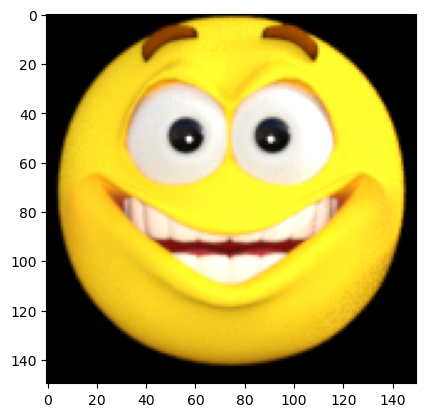


Sample sad image:


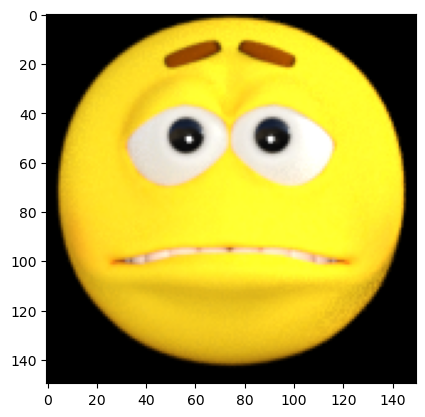

In [3]:
base_dir = "./data/"
happy_dir = os.path.join(base_dir, "happy/")
sad_dir = os.path.join(base_dir, "sad/")

print("Sample happy image:")
plt.figure()
plt.imshow(preprocessing.image.load_img(f"{os.path.join(happy_dir, os.listdir(happy_dir)[0])}"))
plt.show()

print("\nSample sad image:")
plt.figure()
plt.imshow(preprocessing.image.load_img(f"{os.path.join(sad_dir, os.listdir(sad_dir)[0])}"))
plt.show()

It is cool to be able to see examples of the images to better understand the problem-space you are dealing with. 

However there is still some relevant information that is missing such as the resolution of the image (although matplotlib renders the images in a grid providing a good idea of these values) and the maximum pixel value (this is important for normalizing these values). For this you can use Keras as shown in the next cell:

In [4]:
# Load the first example of a happy face
sample_image  = preprocessing.image.load_img(f"{os.path.join(happy_dir, os.listdir(happy_dir)[0])}")

# Convert the image into its numpy array representation
sample_array = preprocessing.image.img_to_array(sample_image)

print(f"Each image has shape: {sample_array.shape}")

print(f"The maximum pixel value used is: {np.max(sample_array)}")

Each image has shape: (150, 150, 3)
The maximum pixel value used is: 255.0


Looks like the images have a resolution of 150x150. **This is very important because this will be the input size of the first layer in your network.** 

**The last dimension refers to each one of the 3 RGB channels that are used to represent colored images.**

## Defining the callback

Since you already have coded the callback responsible for stopping training (once a desired level of accuracy is reached) in the previous two assignments this time it is already provided so you can focus on the other steps:

In [5]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') is not None and logs.get('accuracy') > 0.999:
            print("\nReached 99.9% accuracy so cancelling training!")
            self.model.stop_training = True    

A quick note on callbacks: 

So far you have used only the `on_epoch_end` callback but there are many more. For example you might want to check out the [EarlyStopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) callback, which allows you to save the best weights for your model.

## Pre-processing the data

Keras provides great support for preprocessing image data. A lot can be accomplished by using the `ImageDataGenerator` class. Be sure to check out the [docs](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) if you get stuck in the next exercise. In particular you might want to pay attention to the `rescale` argument when instantiating the `ImageDataGenerator` and to the [`flow_from_directory`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_directory) method.

In [6]:
# GRADED FUNCTION: image_generator
def image_generator():
    ### START CODE HERE

    # Instantiate the ImageDataGenerator class.
    # Remember to set the rescale argument.
    scale = layers.Rescaling(scale=1. / 255)

    # Specify the method to load images from a directory and pass in the appropriate arguments:
    # - directory: should be a relative path to the directory containing the data
    # - targe_size: set this equal to the resolution of each image (excluding the color dimension)
    # - batch_size: number of images the generator yields when asked for a next batch. Set this to 10.
    # - class_mode: How the labels are represented. Should be one of "binary", "categorical" or "sparse".
    #               Pick the one that better suits here given that the labels are going to be 1D binary labels.
    train_generator = utils.image_dataset_from_directory(directory='./data/',  # This is the source directory for training images
                                                         image_size=(150, 150),  # All images will be resized to 300x300
                                                         batch_size=10,
                                                         # Since we use binary_crossentropy loss, we need binary labels
                                                         label_mode='binary')
    
    train_generator = train_generator.map(lambda image, label: (scale(image), label))
    ### END CODE HERE
    
    return train_generator

In [7]:
# Save your generator in a variable
gen = image_generator()

Found 80 files belonging to 2 classes.


2024-06-10 19:52:05.036371: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1693 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


**Expected Output:**
```
Found 80 images belonging to 2 classes.
```

## Creating and training your model

Finally, complete the `train_happy_sad_model` function below. This function should return your  neural network.

**Your model should achieve an accuracy of 99.9% or more before 15 epochs to pass this assignment.**

**Hints:**
- You can try any architecture for the network but keep in mind that the model will work best with 3 convolutional layers. 


- In case you need extra help you can check out some tips at the end of this notebook.

In [8]:
# GRADED FUNCTION: train_happy_sad_model
def train_happy_sad_model(train_generator):
    # Instantiate the callback
    callbacks = myCallback()

    ### START CODE HERE

    # Define the model
    model = Sequential([Input(shape=(150, 150, 3)),
                        # First convolution
                        layers.Conv2D(16, (3, 3), activation='relu'),
                        layers.MaxPooling2D(2, 2),
                        # Second convolution
                        layers.Conv2D(16, (3, 3), activation='relu'),
                        layers.MaxPooling2D(2, 2),
                        # Third convolution
                        layers.Conv2D(16, (3, 3), activation='relu'),
                        layers.MaxPooling2D(2, 2),
                        # Flatten
                        layers.Flatten(),
                        # Dense layers
                        layers.Dense(512, activation='relu'),
                        layers.Dense(1, activation='sigmoid')])

    # Compile the model
    # Select a loss function compatible with the last layer of your network
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizers.RMSprop(learning_rate=0.001),
                  metrics=['accuracy'])     

    # Train the model
    # Your model should achieve the desired accuracy in less than 15 epochs.
    # You can hardcode up to 20 epochs in the function below but the callback should trigger before 15.
    history = model.fit(x=train_generator,
                        epochs=20,
                        callbacks=[callbacks])
    
    ### END CODE HERE
    return history

In [9]:
hist = train_happy_sad_model(gen)

Epoch 1/20


I0000 00:00:1718070727.218170   49516 service.cc:145] XLA service 0x7fc7f4001810 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1718070727.218202   49516 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2024-06-10 19:52:07.247138: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-10 19:52:07.356977: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5143 - loss: 0.8503
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8216 - loss: 0.4509 
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9555 - loss: 0.1799 
Epoch 4/20


I0000 00:00:1718070728.985232   49516 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9257 - loss: 0.1399 
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9683 - loss: 0.1077 
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9395 - loss: 0.1422 
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9538 - loss: 0.1023 
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9752 - loss: 0.0590 
Epoch 9/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9313 - loss: 0.1297 
Epoch 10/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9368 - loss: 0.1254 
Epoch 11/20
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 1.0000 - loss: 0.0107
Reached 99.9% accuracy so cancelling training!
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0184 


If you see the message that was defined in the callback printed out after less than 15 epochs it means your callback worked as expected and training was successful. You can also double check by running the following cell:

In [10]:
print(f"Your model reached the desired accuracy after {len(hist.epoch)} epochs")

Your model reached the desired accuracy after 11 epochs


If your callback didn't stop training, one cause might be that you compiled your model using a metric other than `accuracy` (such as `acc`). Make sure you set the metric to `accuracy`. You can check by running the following cell:

In [11]:
if not "accuracy" in hist.model.metrics_names:
    print("Use 'accuracy' as metric when compiling your model.")
else:
    print("The metric was correctly defined.")

Use 'accuracy' as metric when compiling your model.


## Need more help?

Run the following cell to see some extra tips for the model's architecture.

In [12]:
encoded_answer = "ClNvbWUgaGVscGZ1bCB0aXBzIGluIGNhc2UgeW91IGFyZSBzdHVjazoKCiAgICAtIEEgZ29vZCBmaXJzdCBsYXllciB3b3VsZCBiZSBhIENvbnYyRCBsYXllciB3aXRoIGFuIGlucHV0IHNoYXBlIHRoYXQgbWF0Y2hlcyAKICAgIHRoYXQgb2YgZXZlcnkgaW1hZ2UgaW4gdGhlIHRyYWluaW5nIHNldCAoaW5jbHVkaW5nIHRoZSBjb2xvciBkaW1lbnNpb24pCiAgICAKICAgIC0gVGhlIG1vZGVsIHdpbGwgd29yayBiZXN0IHdpdGggMyBjb252b2x1dGlvbmFsIGxheWVycwogICAgCiAgICAtIFRoZXJlIHNob3VsZCBiZSBhIEZsYXR0ZW4gbGF5ZXIgaW4gYmV0d2VlbiBjb252b2x1dGlvbmFsIGFuZCBkZW5zZSBsYXllcnMKICAgIAogICAgLSBUaGUgZmluYWwgbGF5ZXIgc2hvdWxkIGJlIGEgRGVuc2UgbGF5ZXIgd2l0aCB0aGUgbnVtYmVyIG9mIHVuaXRzIGFuZCAKICAgIGFjdGl2YXRpb24gZnVuY3Rpb24gdGhhdCBzdXBwb3J0cyBiaW5hcnkgY2xhc3NpZmljYXRpb24uCg=="
encoded_answer = encoded_answer.encode('ascii')
answer = base64.b64decode(encoded_answer)
answer = answer.decode('ascii')

print(answer)


Some helpful tips in case you are stuck:

    - A good first layer would be a Conv2D layer with an input shape that matches 
    that of every image in the training set (including the color dimension)
    
    - The model will work best with 3 convolutional layers
    
    - There should be a Flatten layer in between convolutional and dense layers
    
    - The final layer should be a Dense layer with the number of units and 
    activation function that supports binary classification.



**Congratulations on finishing the last assignment of this course!**

You have successfully implemented a CNN to assist you in the classification task for complex images. Nice job!

**Keep it up!**

In [13]:
!rm -rf ./data